In [1]:
# 1. SAM2 및 필수 라이브러리 설치
!pip install ultralytics -q
!pip install git+https://github.com/facebookresearch/sam2.git -q

# 2. SAM2 체크포인트 다운로드 (Large 모델 사용 - A100이니까!)
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

import torch
import os
import zipfile
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

# GPU 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Device: {device} (A100 Verified)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Device: cpu (A100 Verified)


In [4]:
from google.colab import drive
import os

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')
# 파일 경로 설정
growth_model_path = '/content/drive/MyDrive/cv2/runs/tomato_seg_v8m_final/weights/best.pt'
disease_zip_path = '/content/drive/MyDrive/cv2/tomato_seg_v11M_final_resq.zip'
sam2_checkpoint = "sam2_hiera_large.pt"
sam2_config = "sam2_hiera_l.yaml" # SAM2 내부 설정 파일

# 질병 모델 압축 해제
# 압축 해제 경로는 동일
extract_path = '/content/disease_model'

# 1. 먼저 'best.pt'를 찾는다 (우선순위 1위)
best_candidates = glob.glob(f"{extract_path}/**/best.pt", recursive=True)

if best_candidates:
    disease_model_path = best_candidates[0]
    print(f"✅ 'best.pt'를 찾았습니다! 이걸로 로드합니다: {disease_model_path}")
else:
    # 2. 만약 'best.pt'가 없으면 차선책으로 다른 .pt(last.pt 등)를 찾는다
    print("⚠️ 주의: 'best.pt'가 발견되지 않았습니다. 다른 모델을 찾습니다...")
    all_candidates = glob.glob(f"{extract_path}/**/*.pt", recursive=True)

    if all_candidates:
        disease_model_path = all_candidates[0]
        print(f"✅ 대체 모델 로드: {disease_model_path}")
    else:
        raise FileNotFoundError("❌ 폴더 내에 .pt 파일이 아예 없습니다. 압축 파일 내용을 확인해주세요.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 'best.pt'를 찾았습니다! 이걸로 로드합니다: /content/disease_model/content/runs/tomato_seg_v11M_final_resq/weights/best.pt


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import torch.nn.functional as F
import os

# GPU 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

class TomatoDoctorIntegrated:
    def __init__(self, growth_path, disease_path, sam2_ckpt, sam2_conf):
        print("🏥 토마토 통합 진단 시스템 가동 (One-View 모드)...")
        self.growth_model = YOLO(growth_path)
        self.disease_model = YOLO(disease_path)

        print("🔹 SAM2 모델 로드 중...")
        sam2 = build_sam2(sam2_conf, sam2_ckpt, device=device)
        self.sam2_predictor = SAM2ImagePredictor(sam2)
        print("✅ 시스템 준비 완료!")

    def analyze(self, image_path, disease_conf=0.2):
        img = cv2.imread(image_path)
        if img is None: raise ValueError("이미지를 찾을 수 없습니다.")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 1. 생장 분석
        growth_res = self.growth_model.predict(img, conf=0.3, verbose=False)[0]

        # 2. 질병 분석
        disease_res = self.disease_model.predict(img, conf=disease_conf, verbose=False)[0]
        boxes = disease_res.boxes.xyxy.cpu().numpy()

        disease_masks = []
        if len(boxes) > 0:
            self.sam2_predictor.set_image(img_rgb)
            masks, _, _ = self.sam2_predictor.predict(box=boxes, multimask_output=False)
            disease_masks = masks.squeeze(1)

        return {
            'image': img_rgb,
            'growth_res': growth_res,
            'disease_res': disease_res,
            'disease_masks': disease_masks
        }

    def visualize(self, result):
        # 캔버스 준비
        vis_img = result['image'].copy()
        h, w = vis_img.shape[:2]

        # 폰트 스케일 자동 조절 (이미지 크기 비례)
        font_scale = max(0.8, w / 1500.0)
        thickness = max(2, int(font_scale * 2))

        # 마스크 오버레이용 레이어
        overlay = vis_img.copy()

        # ---------------------------------------------------------
        # 1. 생장(Growth) 시각화 - 은은한 배경색 채우기
        # ---------------------------------------------------------
        g_res = result['growth_res']
        if g_res.masks is not None:
            g_masks = g_res.masks.data.cpu().numpy()

            # 마스크 리사이징 (필요시)
            if g_masks.shape[1:] != (h, w):
                g_masks_tensor = torch.from_numpy(g_masks).unsqueeze(1).float()
                g_masks = F.interpolate(g_masks_tensor, size=(h, w), mode='bilinear', align_corners=False).squeeze(1).cpu().numpy()

            for i, mask in enumerate(g_masks):
                mask_bool = (mask > 0.5)
                cls_id = int(g_res.boxes.cls[i])

                # 색상 지정 (BGR 기준: OpenCV draw용)
                # 0:완숙(Red), 1:반숙(Orange), 2:미숙(Green) 등 클래스 ID에 맞춰 수정 필요
                # 예시 색상: 완숙(빨강), 그외(초록/주황)
                if cls_id == 0: color = (255, 0, 0) # Red
                else: color = (0, 255, 0) # Green (임의 설정)

                # 마스크 채우기
                overlay[mask_bool] = color

        # ---------------------------------------------------------
        # 2. 질병(Disease) 시각화 - 진한 테두리 및 반투명 채우기
        # ---------------------------------------------------------
        d_res = result['disease_res']
        d_masks = result['disease_masks']

        if len(d_masks) > 0:
            for i, mask in enumerate(d_masks):
                mask_bool = (mask > 0.5)
                # 질병은 보라색/마젠타 계열로 강조
                disease_color = (255, 0, 255)

                # 질병 부위 덧칠
                overlay[mask_bool] = disease_color

                # 외곽선 그리기 (SAM2 마스크 기반)
                contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(vis_img, contours, -1, (255, 0, 255), thickness + 2) # 원본에 바로 그림 (진하게)

        # 마스크 합성 (생장+질병 색상 블렌딩)
        vis_img = cv2.addWeighted(vis_img, 0.6, overlay, 0.4, 0)

        # ---------------------------------------------------------
        # 3. 라벨링 (Bounding Box Corner)
        # ---------------------------------------------------------

        # 텍스트 그리기 헬퍼
        def put_label(img, text, x, y, bg_color):
            (t_w, t_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
            # 배경 박스
            cv2.rectangle(img, (x, y - t_h - 5), (x + t_w + 4, y + 5), bg_color, -1)
            # 글씨
            cv2.putText(img, text, (x + 2, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)
            return y + baseline + 10 # 다음 라벨을 위해 y 좌표 증가값 반환

        # (1) 생장 라벨 먼저 그리기
        # 박스 좌표와 라벨 정보를 매핑
        growth_boxes = g_res.boxes.xyxy.cpu().numpy()
        for i, box in enumerate(growth_boxes):
            x1, y1, x2, y2 = map(int, box)
            cls_id = int(g_res.boxes.cls[i])
            label = f"{g_res.names[cls_id]} {g_res.boxes.conf[i]:.2f}"

            # 초록색/검정색 배경
            put_label(vis_img, label, x1, y1 - 10, (0, 100, 0))

        # (2) 질병 라벨 그리기 (생장 라벨과 겹치지 않게 위치 조정 로직 포함 가능하나, 단순화를 위해 박스 위로 올림)
        # 만약 박스가 비슷하면 y축을 조금 내려서 그림
        disease_boxes = d_res.boxes.xyxy.cpu().numpy()
        for i, box in enumerate(disease_boxes):
            x1, y1, x2, y2 = map(int, box)
            cls_id = int(d_res.boxes.cls[i])
            label = f"! {d_res.names[cls_id]} {d_res.boxes.conf[i]:.2f}"

            # 위치 조정: 생장 라벨이 있을 위치(y1)보다 살짝 아래에 그리거나,
            # 확실하게 구분되도록 빨간 배경 사용
            # 간단한 휴리스틱: 질병 라벨은 박스 안쪽 상단에 배치하여 외부 생장 라벨과 구분
            put_label(vis_img, label, x1, y1 + 35, (200, 0, 0))

        # 최종 출력
        plt.figure(figsize=(12, 12))
        plt.imshow(vis_img)
        plt.axis('off')
        plt.title("Integrated Analysis: Growth (Green/Bg) & Disease (Red/Fg)", fontsize=15)
        plt.show()

# --- 실행부 ---
# 경로 설정 (사용자 환경에 맞게 수정)
# sam2_conf = "sam2_hiera_l.yaml"
# sam2_ckpt = "sam2_hiera_large.pt"
# doctor = TomatoDoctorIntegrated("growth_best.pt", "disease_best.pt", sam2_ckpt, sam2_conf)

# target_img_path = '/content/drive/MyDrive/cv2/Laboro_Tomato/val/images/IMG_0986.jpg'
# if os.path.exists(target_img_path):
#    results = doctor.analyze(target_img_path, disease_conf=0.15)
#    doctor.visualize(results)

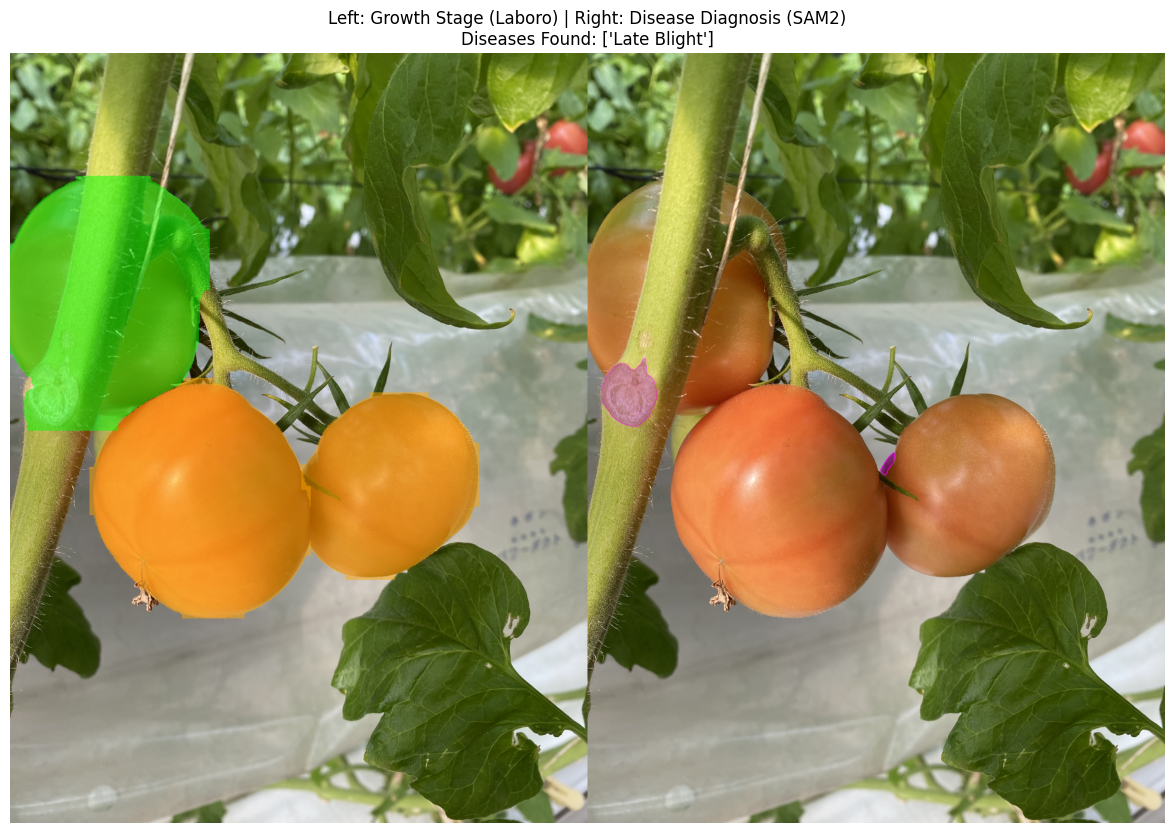

In [22]:
# 테스트할 이미지 경로 입력
target_img_path = '/content/drive/MyDrive/cv2/Laboro_Tomato/val/images/IMG_0986.jpg' # 예시

# 분석 실행 (질병 민감도 0.1 ~ 0.3 조절 권장)
if os.path.exists(target_img_path):
    results = doctor.analyze(target_img_path, disease_conf=0.15)
    doctor.visualize(results)
else:
    print("이미지 경로를 확인해주세요.")

🚀 Device: cpu
✅ SAM2 파일 확인됨: /content/drive/MyDrive/cv2/weights/sam2_hiera_large.pt

🏥 [시스템 재가동] 토마토 통합 진단 (Auto-Save Mode)...
🔹 SAM2 모델 로드 중...
✅ 시스템 준비 완료!
📸 분석 시작: /content/drive/MyDrive/cv2/plantseg_tomato/images/train/tomato_early_blight_1.jpg
💾 [저장 완료] /content/drive/MyDrive/cv2/analysis_results/tomato_early_blight_1_analyzed.jpg


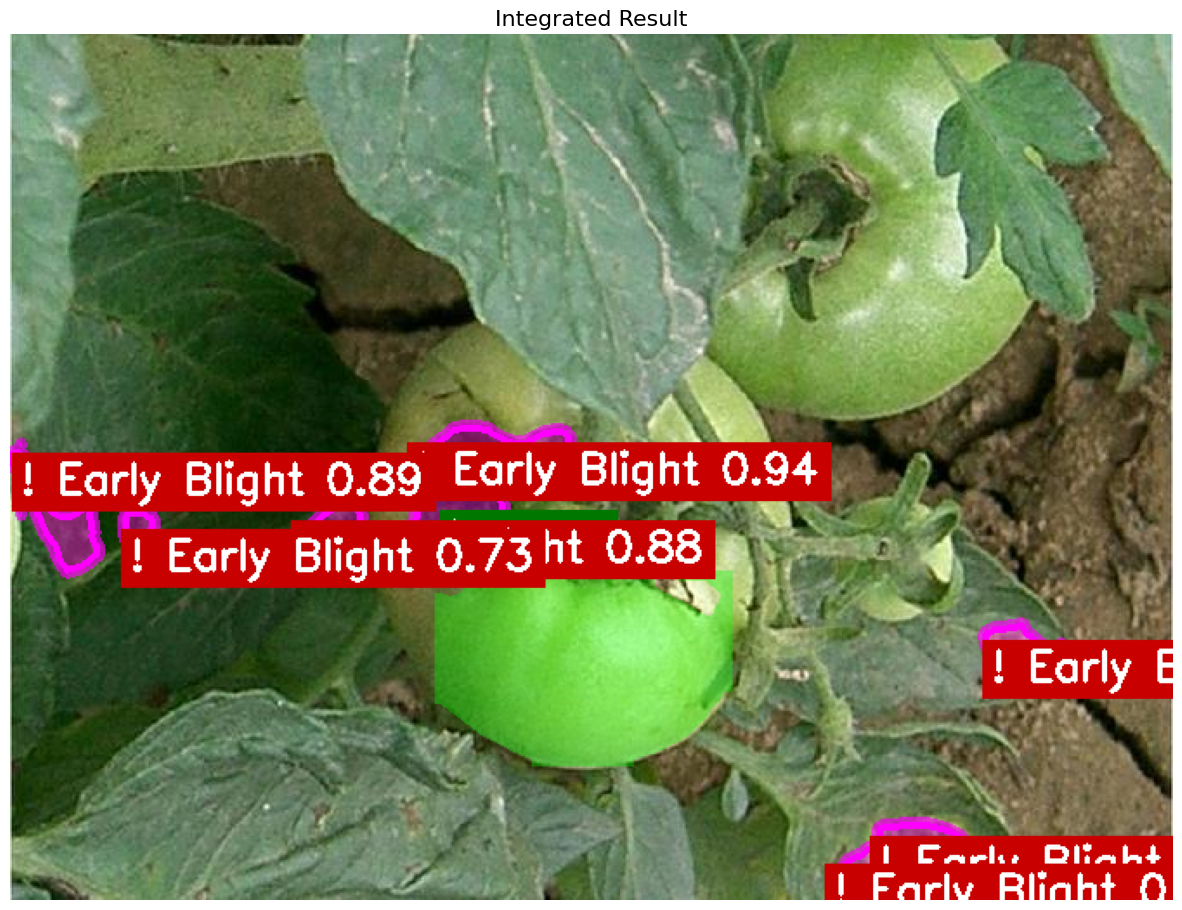

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
import torch.nn.functional as F
import os
import glob

# 1. GPU 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Device: {device}")

# ========================================================
# 2. [수정됨] 모델 경로 설정 (여기를 고쳤습니다)
# ========================================================
growth_model_path = '/content/drive/MyDrive/cv2/runs/tomato_seg_v8m_final/weights/best.pt'

# 🚨 수정된 부분: 파일명만 쓰지 말고 전체 경로를 넣어야 합니다.
sam2_checkpoint = "/content/drive/MyDrive/cv2/weights/sam2_hiera_large.pt"
sam2_config = "sam2_hiera_l.yaml"

# 경로가 진짜 있는지 확인 (없으면 에러 메시지 출력)
if not os.path.exists(sam2_checkpoint):
    print(f"❌ 오류: SAM2 파일이 {sam2_checkpoint} 경로에 없습니다. 경로를 다시 확인하세요.")
else:
    print(f"✅ SAM2 파일 확인됨: {sam2_checkpoint}")

# 질병 모델 경로 찾기
extract_path = '/content/disease_model'
best_candidates = glob.glob(f"{extract_path}/**/best.pt", recursive=True)
if best_candidates:
    disease_model_path = best_candidates[0]
else:
    all_candidates = glob.glob(f"{extract_path}/**/*.pt", recursive=True)
    disease_model_path = all_candidates[0] if all_candidates else '/content/disease_model/runs/detect/train/weights/best.pt'

# 3. 통합 진단 클래스 정의
class TomatoDoctorIntegrated:
    def __init__(self, growth_path, disease_path, sam2_ckpt, sam2_conf):
        print("\n🏥 [시스템 재가동] 토마토 통합 진단 (Auto-Save Mode)...")
        self.growth_model = YOLO(growth_path)
        self.disease_model = YOLO(disease_path)

        print("🔹 SAM2 모델 로드 중...")
        # 여기서 에러가 났던 것임 -> 이제 경로가 맞아서 해결될 것임
        sam2 = build_sam2(sam2_conf, sam2_ckpt, device=device)
        self.sam2_predictor = SAM2ImagePredictor(sam2)
        print("✅ 시스템 준비 완료!")

    def analyze(self, image_path, disease_conf=0.2):
        img = cv2.imread(image_path)
        if img is None: raise ValueError("이미지를 찾을 수 없습니다.")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        growth_res = self.growth_model.predict(img, conf=0.3, verbose=False)[0]
        disease_res = self.disease_model.predict(img, conf=disease_conf, verbose=False)[0]
        boxes = disease_res.boxes.xyxy.cpu().numpy()

        disease_masks = []
        if len(boxes) > 0:
            self.sam2_predictor.set_image(img_rgb)
            masks, _, _ = self.sam2_predictor.predict(box=boxes, multimask_output=False)
            disease_masks = masks.squeeze(1)

        return {
            'image': img_rgb,
            'growth_res': growth_res,
            'disease_res': disease_res,
            'disease_masks': disease_masks
        }

    def visualize(self, result, save_path=None):
        vis_img = result['image'].copy()
        h, w = vis_img.shape[:2]

        font_scale = max(0.8, w / 1000.0)
        thickness = max(2, int(font_scale * 2))
        overlay = vis_img.copy()

        # [Step 1] 생장 시각화
        g_res = result['growth_res']
        if g_res.masks is not None:
            g_masks = g_res.masks.data.cpu().numpy()
            if g_masks.shape[1:] != (h, w):
                g_masks_tensor = torch.from_numpy(g_masks).unsqueeze(1).float()
                g_masks = F.interpolate(g_masks_tensor, size=(h, w), mode='bilinear', align_corners=False).squeeze(1).cpu().numpy()

            for i, mask in enumerate(g_masks):
                if mask.max() < 0.5: continue
                mask_bool = (mask > 0.5)
                cls_id = int(g_res.boxes.cls[i])
                color = (255, 0, 0) if cls_id == 0 else (0, 255, 0)
                overlay[mask_bool] = color

        # [Step 2] 질병 시각화
        d_res = result['disease_res']
        d_masks = result['disease_masks']
        if len(d_masks) > 0:
            for i, mask in enumerate(d_masks):
                mask_bool = (mask > 0.5)
                disease_color = (255, 0, 255)
                overlay[mask_bool] = disease_color
                contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(vis_img, contours, -1, (255, 0, 255), thickness + 3)

        vis_img = cv2.addWeighted(vis_img, 0.65, overlay, 0.35, 0)

        # [Step 3] 라벨링
        def put_label(img, text, x, y, bg_color):
            (t_w, t_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
            cv2.rectangle(img, (x, y - t_h - 10), (x + t_w + 10, y + 5), bg_color, -1)
            cv2.putText(img, text, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        for i, box in enumerate(g_res.boxes.xyxy.cpu().numpy()):
            x1, y1, x2, y2 = map(int, box)
            cls_name = g_res.names[int(g_res.boxes.cls[i])]
            put_label(vis_img, f"{cls_name}", x1, y1 - 10, (0, 120, 0))

        for i, box in enumerate(d_res.boxes.xyxy.cpu().numpy()):
            x1, y1, x2, y2 = map(int, box)
            cls_name = d_res.names[int(d_res.boxes.cls[i])]
            conf = d_res.boxes.conf[i]
            put_label(vis_img, f"! {cls_name} {conf:.2f}", x1, y1 + 40, (200, 0, 0))

        # [Step 4] 저장
        if save_path:
            save_img = cv2.cvtColor(vis_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(save_path, save_img)
            print(f"💾 [저장 완료] {save_path}")

        plt.figure(figsize=(15, 15))
        plt.imshow(vis_img)
        plt.axis('off')
        plt.title(f"Integrated Result", fontsize=16)
        plt.show()

# ========================================================
# 4. 실행 및 저장 설정
# ========================================================
doctor = TomatoDoctorIntegrated(growth_model_path, disease_model_path, sam2_checkpoint, sam2_config)

target_img_path = '/content/drive/MyDrive/cv2/plantseg_tomato/images/train/tomato_early_blight_1.jpg'
save_folder = '/content/drive/MyDrive/cv2/analysis_results'
os.makedirs(save_folder, exist_ok=True)


if os.path.exists(target_img_path):
    print(f"📸 분석 시작: {target_img_path}")
    results = doctor.analyze(target_img_path, disease_conf=0.15)

    filename = os.path.basename(target_img_path)
    filename_no_ext = os.path.splitext(filename)[0]
    save_full_path = os.path.join(save_folder, f"{filename_no_ext}_analyzed.jpg")

    doctor.visualize(results, save_path=save_full_path)
else:
    print("❌ 이미지 경로를 찾을 수 없습니다.")

In [24]:
import shutil
import os

# 드라이브에 저장할 경로 (없으면 폴더 생성)
drive_save_path = '/content/drive/MyDrive/cv2/weights/'
os.makedirs(drive_save_path, exist_ok=True)

# 파일 이동
if os.path.exists('/content/sam2_hiera_large.pt'):
    shutil.move('/content/sam2_hiera_large.pt', os.path.join(drive_save_path, 'sam2_hiera_large.pt'))
    print(f"✅ 파일이 {drive_save_path} 로 이동되었습니다.")
else:
    print("⚠️ 이미 이동했거나 파일이 없습니다.")

✅ 파일이 /content/drive/MyDrive/cv2/weights/ 로 이동되었습니다.
